#           Fitting Effective Model parameters

## Initialization 

In [3]:
from model import form as md

In [4]:
import numpy as np
from numpy.linalg import inv

In [5]:
%matplotlib inline
# %matplotlib notebook
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

In [6]:
import timeit
import time

In [7]:
import os

In [8]:
from scipy.optimize import lsq_linear
from scipy.optimize import minimize

In [9]:
import nlopt

In [10]:
from tkinter import*
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

from tkinter import filedialog

## Import required data

### Import GUI

In [11]:
#   Open the import file GUI
##  Remember to look at your list of Apps
infiles = filedialog.askopenfilename(multiple=True)
%gui tk

In [12]:
# The file that gets imported
infiles[0]

'/Users/willwiz/Downloads/Will-Rana-selected/specimen1/iso_wc/iso1data.txt'

In [13]:
importeddata = np.loadtxt(infiles[0])

In [14]:
importedconsdata = np.loadtxt(os.path.join(os.path.dirname(os.path.realpath(infiles[0])), 'consdata.txt'))

### Data processing

In [15]:
data_size = importeddata[:,1].size
print(data_size)

1113


In [16]:
Fdata = importeddata[:,[0,1,2,3]]

In [17]:
# Import the deformation gradient tensor from the data
ftensor = np.zeros((data_size,2,2))
ftensor[:,0,0] = importeddata[:,0]
ftensor[:,0,1] = importeddata[:,1]
ftensor[:,1,0] = importeddata[:,2]
ftensor[:,1,1] = importeddata[:,3]
# Import the 2nd PK tensor from the data
Stensor = np.zeros((data_size,2,2))
Stensor[:,0,0] = importeddata[:,4]
Stensor[:,0,1] = importeddata[:,5]
Stensor[:,1,0] = importeddata[:,5]
Stensor[:,1,1] = importeddata[:,6]

In [18]:
# Compute the Cauchy stress the deformation gradient tensor from the data
Ttensor = np.zeros((data_size,2,2))
for i in range(data_size):
    Ttensor[i] = ftensor[i].dot(Stensor[i]).dot(ftensor[i].T)

In [19]:
## Low stress region points
ls_datapoints = np.array([ n for n,i in enumerate(Stensor) if i[0,0] < 50 and i[0,1] < 50 and i[1,1] < 50])

#### Compute the preferred direction

In [20]:
M = np.array([1,0])

In [21]:
S = np.array([-M[1], M[0]])

In [22]:
ftensor[1]

array([[ 0.9       , -0.20069602],
       [ 0.        ,  1.        ]])

In [23]:
m = np.zeros((data_size,2))
for i in range(data_size):
    m[i] = md.calc_m(Fdata[i], M)

In [24]:
s = np.zeros((data_size,2))
for i in range(data_size):
    s[i] = md.cross_2D(m[i])

#### Compute the kinematic variables

In [25]:
dat_lambdaM = np.zeros(data_size)
dat_lambdaS = np.zeros(data_size)
dat_phi = np.zeros(data_size)

In [26]:
## for lambda_M 
for i in range(data_size):
    dat_lambdaM[i] = md.lambda_M(Fdata[i], M) #m[i].dot(ftensor[i]).dot(M)
    
## for lambda_S
for i in range(data_size):
    dat_lambdaS[i] = md.lambda_S(Fdata[i], M) #s[i].dot(ftensor[i]).dot(S)

## for phi_M
for i in range(data_size):
    dat_phi[i] = md.phi(Fdata[i], M) #m[i].dot(ftensor[i]).dot(S)/dat_lambdaM[i]

In [27]:
dat_gamma1 = np.log(dat_lambdaM)
dat_gamma2 = np.log(dat_lambdaS)
dat_gamma3 = dat_phi

In [28]:
gamma1 = dat_gamma1
gamma2 = dat_gamma2
gamma3 = dat_gamma3

#### Compute the response function variables

In [29]:
W1 = np.zeros(data_size)
W2 = np.zeros(data_size)
W3 = np.zeros(data_size)

In [30]:
for i in range(data_size):
    W1[i] = m[i].dot(Ttensor[i]).dot(m[i])

In [31]:
for i in range(data_size):
    W2[i] = s[i].dot(Ttensor[i]).dot(s[i])

In [32]:
for i in range(data_size):
    W3[i] = m[i].dot(Ttensor[i]).dot(s[i]) * dat_lambdaM[i] / dat_lambdaS[i]

In [33]:
Wvector = np.concatenate((W1,W2,W3))

## Define the model 

### Define the model form

### Define the response functions

### Define the stiffness functions

In [34]:
def rW1(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    lm2 = np.exp(g1)**2
    ls2 = np.exp(g2)**2
    phi = g3
    return -(phi**2 /lm2/ls2 + .5 * phi**4 /ls2/ls2)*dW2(*x) \
            +(2*phi*dW3(*x) - 0.5*dW1(*x) + 0.25*dW11(*x) + phi**2 * dW33(*x) - phi*dW13(*x))/lm2/lm2 \
            +phi**2 /lm2/ls2 * (.5*dW12(*x) - phi*dW23(*x)) + 0.25 * phi**4 /ls2/ls2 * dW22(*x)

In [35]:
def rW2(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    lm2 = np.exp(g1)**2
    ls2 = np.exp(g2)**2
    phi = g3
    return 0.5*(phi/lm2/ls2 + phi**3/ls2/ls2) * dW2(*x) \
            +0.5/lm2/lm2*(0.5*dW13(*x) - dW3(*x) - phi*dW33(*x)) \
            +0.25*phi/lm2/ls2*(3*phi*dW23(*x) - dW12(*x)) - 0.25 * phi**3 /ls2/ls2 * dW22(*x)

In [36]:
def rW3(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    lm2 = np.exp(g1)**2
    ls2 = np.exp(g2)**2
    phi = g3
    return 0.25 * phi**2/ls2/ls2 *(dW22(*x) - 2*dW2(*x)) + 0.25/lm2/ls2*(dW12(*x) - 2*phi*dW23(*x))

In [37]:
def rW4(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    lm2 = np.exp(g1)**2
    ls2 = np.exp(g2)**2
    phi = g3
    return -(0.25/lm2 + 0.5*phi**2/ls2)/ls2*dW2(*x) + 0.25 * phi**2 /ls2/ls2*dW22(*x) \
            +0.25/lm2/lm2*dW33(*x) - 0.5*phi/lm2/ls2 * dW23(*x)

In [38]:
def rW5(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    lm2 = np.exp(g1)**2
    ls2 = np.exp(g2)**2
    phi = g3
    return 0.25*phi/ls2/ls2*(2*dW2(*x) - dW22(*x)) + 0.25/lm2/ls2*dW23(*x)

In [39]:
def rW6(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    ls2 = np.exp(g2)**2
    return 0.25/ls2/ls2*(dW22(*x) - 2*dW2(*x))

### Define the stress

## Precompute the problem

### Define the response matrix

### Define the elasticity matrix

### Precompute the response matrix

In [41]:

Wvector = np.concatenate((W1,W2,W3))

### Precompute the elasticity matrix

## Fit the low stress region

### Data processing

### Functions

### Parameter optimization

### Plot the results

##### Plot for W1

### Post processing to remove the toe region

## Define the optimization problem

### Define the objective function

### Define the constraint functions

## Forward Selection: Model enhancement

## Model parameter covariance

### Compute the covariance matrix 

### Parameter fitness

## Backwards Elimination: Model refinement

In [42]:
def obj_f(const):
    sse = 0.0
    for i in range(data_size):
        e1 = md.model_W1(const, Fdata[i], M) - W1[i]
        sse += e1 * e1
        e2 = md.model_W2(const, Fdata[i], M) - W2[i]
        sse += e2 * e2
        e3 = md.model_W3(const, Fdata[i], M) - W3[i]
        sse += e3 * e3
    return sse

In [45]:
ymax = [gamma1.max(), gamma2.max(), gamma3.max()]

In [46]:
def obj_f_s(const):
    sse = 0.0
    for i in range(data_size):
        e1 = md.model_W1_s(const, Fdata[i], M, ymax) - W1[i]
        sse += e1 * e1
        e2 = md.model_W2_s(const, Fdata[i], M, ymax) - W2[i]
        sse += e2 * e2
        e3 = md.model_W3_s(const, Fdata[i], M, ymax) - W3[i]
        sse += e3 * e3
    return sse

In [45]:
obj_f([1,0,0,0,0,0,0])

286897716.53311962

In [47]:
obj_f_s([1,0,0,0,0,0,0])

286897716.53311962

In [1078]:
# def f(x, grad):
#     if grad.size > 0:
#         global model_exp
#         grad[:] = obj_f_jac(x, index[model_exp])
#         return obj_f(x, index[model_exp])

    
# def c(result, x, grad):
#     if grad.size > 0:
#         global model_exp
#         for i in range(ncons):
#             result[3*i] = -constraint1(i, index[model_exp], x)
#             result[3*i + 1] = -constraint4(i, index[model_exp], x)
#             result[3*i + 2] = -constraint7(i, index[model_exp], x)
#             grad[3*i,:] = -cons1_jac(i, index[model_exp], x)
#             grad[3*i + 1,:] = -cons4_jac(i, index[model_exp], x)
#             grad[3*i + 2,:] = -cons7_jac(i, index[model_exp], x)
#     return 0
                 
            

In [1156]:
# del opt

In [1157]:
# lb = np.full(index.size, -10.0e-10)
# ub = np.full(index.size, -10.0e-10)

# for i in cons_positions:
#     lb[i] = 0

In [1158]:
# opt = nlopt.opt(nlopt.LD_MMA, model_exp.size)
# # opt = nlopt.opt(nlopt.GN_ISRES, model_exp.size)
# opt.set_min_objective(f)

# opt.set_lower_bounds(lb[index[model_exp]])
# opt.set_upper_bounds(ub[index[model_exp]])

# opt.set_ftol_rel(1.0e-6)
# opt.set_ftol_abs(0)
# opt.set_xtol_rel(0)
# opt.set_xtol_abs(0)

# opt.set_maxeval(100)
# opt.set_maxtime(900)

# # opt.add_inequality_mconstraint(c, np.full(3*ncons, 1.0e-14))
# # opt.remove_inequality_mconstraint()

In [1159]:
# # ig = np.zeros(model_exp.size)
# temp_sol = inv((Wtensor[:,index[model_exp]].T).dot(Wtensor[:,index[model_exp]])).dot(Wtensor[:,index[model_exp]].T).dot(hs_vec_b)
# # ig = np.sqrt(temp_sol.clip(min=0, max = 1000))
# ig = temp_sol.clip(min=0)
# # ig = np.zeros(model_exp.size)

In [1160]:
# testgrad = np.zeros(model_exp.size)

In [1163]:
# xopt = opt.optimize(ig)

ValueError: nlopt invalid argument

In [1133]:
# print(xopt)
# print(opt.last_optimize_result())
# print(opt.last_optimum_value())

[  7.91392027e+03   4.17906958e+03   3.27872515e+03   3.84676221e+04
   1.01877503e+04   3.42494254e+06   1.02468203e+08   1.38919290e+04
  -6.98021047e+04  -2.06720362e+04   4.09144970e+05  -6.19456514e+04
   1.39481524e+06   8.59242975e+05   4.21965471e+06   3.52828784e+07
   7.18181268e+07  -1.89925818e+05  -1.32978370e+05   5.94249977e+08
   7.62955477e+05   6.43961698e+09   2.72233037e+09   2.37984605e+16]
5
137611796.03163126


In [50]:
ig = np.array([100,20,20,20,20,20,20])

In [58]:
obj_f(np.array([0,0,0,0,0,0,0]))

286897716.53311962

In [57]:
obj_f(ig)

273908599.98248428

In [55]:
optres=minimize(obj_f, ig, method='SLSQP',options={'disp': True, 'maxiter' : 100000, 'iprint': 2})

  NIT    FC           OBJFUN            GNORM
    1     9     1.900606E+09     2.214794E+08


/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:153: RuntimeWarning: overflow encountered in exp
  ans = c[0] * (Q1 * np.exp(Q)).sum()
/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:153: RuntimeWarning: invalid value encountered in multiply
  ans = c[0] * (Q1 * np.exp(Q)).sum()
/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:160: RuntimeWarning: overflow encountered in exp
  ans = c[0] * (Q2 * np.exp(Q)).sum()
/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:167: RuntimeWarning: overflow encountered in exp
  ans = c[0] * (Q3 * np.exp(Q)).sum()
/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:167: RuntimeWarning: invalid value encountered in multiply
  ans = c[0] * (Q3 * np.exp(Q)).sum()
/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:160: RuntimeWarning: invalid value encountered in multiply
  ans 

    2    26     5.693282E+08     1.209975E+07


/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:153: RuntimeWarning: overflow encountered in multiply
  ans = c[0] * (Q1 * np.exp(Q)).sum()


    3    40     3.019462E+08     2.378539E+06
    4    54     2.823091E+08     8.697800E+05


/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:153: RuntimeWarning: overflow encountered in double_scalars
  ans = c[0] * (Q1 * np.exp(Q)).sum()


    5    67     2.601490E+08     4.575631E+06
    6    82     2.600790E+08     4.547149E+06
    7    97     2.600601E+08     4.549433E+06
    8   111     2.600564E+08     4.547559E+06
    9   121     2.469088E+08     2.570377E+06
   10   130     2.391130E+08     2.956679E+06
   11   139     2.336953E+08     6.467470E+06
   12   148     2.080848E+08     4.556986E+06
   13   157     1.929530E+08     4.510714E+06
   14   167     1.791522E+08     4.043451E+06
   15   176     1.653557E+08     3.805151E+06
   16   186     1.594777E+08     2.518785E+06
   17   196     1.575084E+08     1.325590E+06
   18   205     1.569119E+08     8.711337E+05
   19   214     1.546774E+08     9.495073E+05
   20   224     1.512405E+08     1.473272E+06
   21   233     1.477228E+08     3.627431E+06
   22   243     1.455694E+08     2.851535E+06
   23   253     1.416936E+08     1.365223E+06
   24   262     1.408408E+08     5.706470E+06
   25   272     1.381286E+08     3.802710E+06
   26   282     1.367075E+08     2

In [62]:
optres.x

array([ 112.59126215,   14.61609494,   32.8474568 ,    2.70174601,
         15.97174669,    0.29314003,   73.77908302])

In [56]:
ig = np.array([10,20,20,20,20,20,20])

In [57]:
optres=minimize(obj_f_s, ig, method='SLSQP',options={'disp': True, 'maxiter' : 100000, 'iprint': 2})

  NIT    FC           OBJFUN            GNORM
    1     9     2.487898E+08     3.524717E+06
    2    23     1.605043E+08     2.043084E+06


/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:176: RuntimeWarning: overflow encountered in exp
  ans = c[0] * (Q1 * np.exp(Q)).sum()
/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:183: RuntimeWarning: overflow encountered in exp
  ans = c[0] * (Q2 * np.exp(Q)).sum()
/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:183: RuntimeWarning: invalid value encountered in multiply
  ans = c[0] * (Q2 * np.exp(Q)).sum()
/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:190: RuntimeWarning: overflow encountered in exp
  ans = c[0] * (Q3 * np.exp(Q)).sum()
/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:176: RuntimeWarning: invalid value encountered in multiply
  ans = c[0] * (Q1 * np.exp(Q)).sum()
/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:190: RuntimeWarning: invalid value encountered in multiply
  ans 

    3    37     1.140997E+08     1.164032E+06
    4    51     1.072851E+08     1.341094E+06


/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:176: RuntimeWarning: overflow encountered in double_scalars
  ans = c[0] * (Q1 * np.exp(Q)).sum()


    5    65     9.841620E+07     1.529787E+06


/Users/willwiz/Documents/S3-Python/eff-model-parameter-estimation/model/form.py:183: RuntimeWarning: overflow encountered in double_scalars
  ans = c[0] * (Q2 * np.exp(Q)).sum()
/Users/willwiz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in double_scalars


    6    79     9.476198E+07     9.132304E+05
    7    92     9.383394E+07     7.109944E+05
    8   105     9.377701E+07     6.639966E+05
    9   115     9.097721E+07     4.104548E+05
   10   125     9.036865E+07     1.839420E+05
   11   134     8.981239E+07     1.266666E+05
   12   144     8.927734E+07     1.448224E+05
   13   155     8.873803E+07     2.053694E+05
   14   167     8.798167E+07     3.165740E+05
   15   180     8.709361E+07     5.183140E+05
   16   190     8.672280E+07     5.937257E+05
   17   200     8.529188E+07     8.753377E+05
   18   209     8.280870E+07     1.148624E+06
   19   218     7.961436E+07     1.827488E+05
   20   228     7.919746E+07     2.039961E+05
   21   238     7.901453E+07     1.527624E+05
   22   247     7.897021E+07     4.971252E+04
   23   256     7.896924E+07     4.054324E+04
   24   265     7.896829E+07     1.276306E+04
   25   274     7.896810E+07     3.435727E+03
   26   283     7.896808E+07     3.141449E+02
   27   292     7.896808E+07     1

In [60]:
optres_s.x

array([ 112.59136495,   14.6161021 ,   32.84742388,    2.70174922,
         15.97170056,    0.29314999,   73.77931046])

In [1165]:
# finalparameters = parmresults[rterms]
# finalparameters = ig
# finalparameters = xopt
finalparameters = constrainted_results.x

In [1166]:
finalexponenets = index[model_exp]

## Examining the results

### Final parameters

### Quality of fit

In [1167]:
def set_range(g, n):
    delta = (g.max() - g.min()) / n
    return np.arange(g.min(), g.max() + delta/2, delta)

/Users/willwiz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in less


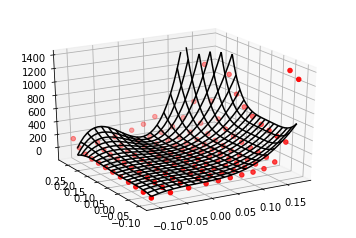

In [1168]:
########################################
# Select the data for plotting
X = []
Y = []
Z = []
for i in range(gamma1.size):
    if abs(gamma3[i]) < np.finfo(float).eps:
        X.append(gamma1[i])
        Y.append(gamma2[i])
        Z.append(W1[i])
        
        
########################################
# Compute the fitted surface
Xsurf = set_range(gamma1, 40)
Ysurf = set_range(gamma2, 40)
Xsurf, Ysurf = np.meshgrid(Xsurf, Ysurf)
Zsurf = np.zeros(Xsurf.shape)
for i in range(Xsurf.shape[0]):
    for j in range(Xsurf.shape[1]):
        Zsurf[i][j] = responseW1(Xsurf[i][j], Ysurf[i][j], 0.0, 
                                 finalparameters, finalexponenets)
        
########################################
# Truncate the surface 
Zsurf[Zsurf>max(Z)] = np.NaN
Zsurf[Zsurf<min(Z)] = np.NaN

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z, c='r', marker='o')
surf = ax.plot_wireframe(Xsurf, Ysurf, Zsurf, rstride=2, cstride=2, color='black')
ax.view_init(elev=25., azim=240)
plt.savefig(infiles[0][:-4]+'fitW1surf.png',dpi=500,bbox_inches='tight')
plt.show()

/Users/willwiz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in less


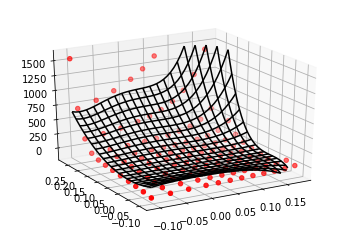

In [1169]:
########################################
# Select the data for plotting
X = []
Y = []
Z = []
for i in range(gamma1.size):
    if abs(gamma3[i]) < np.finfo(float).eps:
        X.append(gamma1[i])
        Y.append(gamma2[i])
        Z.append(W2[i])
        
        
########################################
# Compute the fitted surface
Xsurf = set_range(gamma1, 40)
Ysurf = set_range(gamma2, 40)
Xsurf, Ysurf = np.meshgrid(Xsurf, Ysurf)
Zsurf = np.zeros(Xsurf.shape)
for i in range(Xsurf.shape[0]):
    for j in range(Xsurf.shape[1]):
        Zsurf[i][j] = responseW2(Xsurf[i][j], Ysurf[i][j], 0.0, 
                                 finalparameters, finalexponenets)
        
########################################
# Truncate the surface 
Zsurf[Zsurf>max(Z)] = np.NaN
Zsurf[Zsurf<min(Z)] = np.NaN

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z, c='r', marker='o')
surf = ax.plot_wireframe(Xsurf, Ysurf, Zsurf, rstride=2, cstride=2, color='black')
ax.view_init(elev=25., azim=240)
plt.savefig(infiles[0][:-4]+'fitW2surf.png',dpi=500,bbox_inches='tight')
plt.show()

/Users/willwiz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in less


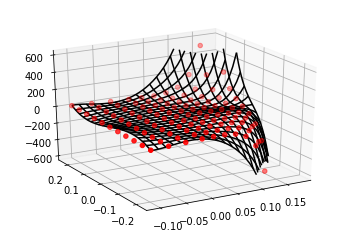

In [1170]:
########################################
# Select the data for plotting
X = []
Y = []
Z = []
for i in range(gamma1.size):
    if abs(gamma2[i]) < np.finfo(float).eps:
        X.append(gamma1[i])
        Y.append(gamma3[i])
        Z.append(W3[i])
        
        
########################################
# Compute the fitted surface
Xsurf = set_range(gamma1, 40)
Ysurf = set_range(gamma3, 40)
Xsurf, Ysurf = np.meshgrid(Xsurf, Ysurf)
Zsurf = np.zeros(Xsurf.shape)
for i in range(Xsurf.shape[0]):
    for j in range(Xsurf.shape[1]):
        Zsurf[i][j] = responseW3(Xsurf[i][j], 0.0, Ysurf[i][j],
                                 finalparameters, finalexponenets)
        
########################################
# Truncate the surface 
Zsurf[Zsurf>max(Z)] = np.NaN
Zsurf[Zsurf<min(Z)] = np.NaN

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z, c='r', marker='o')
surf = ax.plot_wireframe(Xsurf, Ysurf, Zsurf, rstride=2, cstride=2, color='black')
ax.view_init(elev=25., azim=240)
plt.savefig(infiles[0][:-4]+'fitW3surf.png',dpi=500,bbox_inches='tight')
plt.show()

In [1171]:
# ########################################
# # Select the data for plotting
# X = []
# Y = []
# Z = []
# for i in range(gamma1.size):
#     if abs(gamma3[i]) < np.finfo(float).eps:
#         X.append(gamma1[i])
#         Y.append(gamma2[i])
#         Z.append(W1[i])
# ########################################
# # Compute the fitted surface
# Zfit = np.zeros(len(X))
# for i in range(len(X)):
#     Zfit[i] = responseW1(X[i], Y[i], 0.0, finalparameters, finalexponenets)

    
# ########################################
# # Plot the results
# fig_ls_data = plt.figure()
# ax = fig_ls_data.add_subplot(111, projection='3d')
# ax.scatter(X,Y,Z, c='r', marker='o')
# ax.scatter(X,Y,Zfit, c='b', marker='^')
# ax.view_init(elev=25., azim=240)
# ax.set_title(r'$W_1 (kPa)$')
# ax.set_xlabel(r'$\gamma_1$')
# ax.set_ylabel(r'$\gamma_2$')
# plt.savefig(infiles[0][:-4]+'W1scatter.png',dpi=500,bbox_inches='tight')
# plt.show()


In [1172]:
# ########################################
# # Select the data for plotting
# X = []
# Y = []
# Z = []
# for i in range(gamma1.size):
#     if abs(gamma3[i]) < np.finfo(float).eps:
#         X.append(gamma1[i])
#         Y.append(gamma2[i])
#         Z.append(W2[i])
# ########################################
# # Compute the fitted surface
# Zfit = np.zeros(len(X))
# for i in range(len(X)):
#     Zfit[i] = responseW2(X[i], Y[i], 0.0, finalparameters, finalexponenets)

    
# ########################################
# # Plot the results
# fig_ls_data = plt.figure()
# ax = fig_ls_data.add_subplot(111, projection='3d')
# ax.scatter(X,Y,Z, c='r', marker='o')
# ax.scatter(X,Y,Zfit, c='b', marker='^')
# ax.view_init(elev=25., azim=240)
# ax.set_title(r'$W_1 (kPa)$')
# ax.set_xlabel(r'$\gamma_1$')
# ax.set_ylabel(r'$\gamma_2$')
# plt.savefig(infiles[0][:-4]+'W2scatter.png',dpi=500,bbox_inches='tight')
# plt.show()


In [1173]:
# ########################################
# # Select the data for plotting
# X = []
# Y = []
# Z = []
# for i in range(gamma1.size):
#     if abs(gamma1[i]) < np.finfo(float).eps:
#         X.append(gamma2[i])
#         Y.append(gamma3[i])
#         Z.append(W3[i])
# ########################################
# # Compute the fitted surface
# Zfit = np.zeros(len(X))
# for i in range(len(X)):
#     Zfit[i] = responseW3(0.0, X[i], Y[i], finalparameters, finalexponenets)

    
# ########################################
# # Plot the results
# fig_ls_data = plt.figure()
# ax = fig_ls_data.add_subplot(111, projection='3d')
# ax.scatter(X,Y,Z, c='r', marker='o')
# ax.scatter(X,Y,Zfit, c='b', marker='^')
# ax.view_init(elev=25., azim=240)
# ax.set_title(r'$W_1 (kPa)$')
# ax.set_xlabel(r'$\gamma_1$')
# ax.set_ylabel(r'$\gamma_2$')
# plt.savefig(infiles[0][:-4]+'W3scatter.png',dpi=500,bbox_inches='tight')
# plt.show()


### Convexity

/Users/willwiz/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


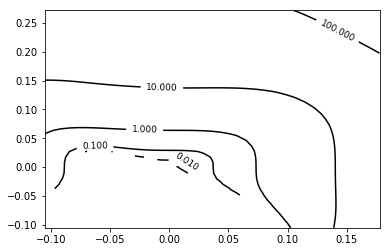

In [1174]:
Xsurf = set_range(gamma1, 40)
Ysurf = set_range(gamma2, 40)
Xsurf, Ysurf = np.meshgrid(Xsurf, Ysurf)
Zenergysurf = np.zeros(Xsurf.shape)
for i in range(Xsurf.shape[0]):
    for j in range(Xsurf.shape[1]):
        Zenergysurf[i][j] = strainenergy(Xsurf[i][j], Ysurf[i][j], 0.0,
                                         finalparameters, finalexponenets)   
        
        
plt.figure()
CS = plt.contour(Xsurf, Ysurf, Zenergysurf, 20,
                 colors='k',locator=plt.LogLocator()# negative contours will be dashed by default
                 )
fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()
plt.clabel(CS, CS.levels, fontsize=9, inline=1)
plt.savefig(infiles[0][:-4]+'fitenergylogcontourlog12.png',dpi=500,bbox_inches='tight')
plt.show()

/Users/willwiz/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


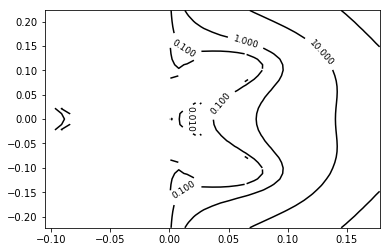

In [1175]:
Xsurf = set_range(gamma1, 40)
Ysurf = set_range(gamma3, 40)
Xsurf, Ysurf = np.meshgrid(Xsurf, Ysurf)
Zenergysurf = np.zeros(Xsurf.shape)
for i in range(Xsurf.shape[0]):
    for j in range(Xsurf.shape[1]):
        Zenergysurf[i][j] = strainenergy(Xsurf[i][j], 0.0, Ysurf[i][j],
                                         finalparameters, finalexponenets)   
        
        
plt.figure()
CS = plt.contour(Xsurf, Ysurf, Zenergysurf, 20,
                 colors='k',locator=plt.LogLocator()# negative contours will be dashed by default
                 )
fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()
plt.clabel(CS, CS.levels, fontsize=9, inline=1)
plt.savefig(infiles[0][:-4]+'fitenergylogcontourlog12.png',dpi=500,bbox_inches='tight')
plt.show()

/Users/willwiz/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


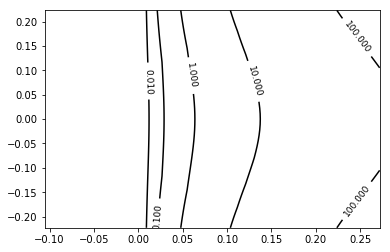

In [1176]:
Xsurf = set_range(gamma2, 40)
Ysurf = set_range(gamma3, 40)
Xsurf, Ysurf = np.meshgrid(Xsurf, Ysurf)
Zenergysurf = np.zeros(Xsurf.shape)
for i in range(Xsurf.shape[0]):
    for j in range(Xsurf.shape[1]):
        Zenergysurf[i][j] = strainenergy(0.0, Xsurf[i][j], Ysurf[i][j], 
                                         finalparameters, finalexponenets)   
        
        
plt.figure()
CS = plt.contour(Xsurf, Ysurf, Zenergysurf, 20,
                 colors='k',locator=plt.LogLocator()# negative contours will be dashed by default
                 )
fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()
plt.clabel(CS, CS.levels, fontsize=9, inline=1)
plt.savefig(infiles[0][:-4]+'fitenergylogcontourlog12.png',dpi=500,bbox_inches='tight')
plt.show()

### Advanced results

In [1177]:
for i in range(ncons):
    print(constraint1(i, finalexponenets, finalparameters))

6938.1859332
13737.5941439
967.481214545
842.981342399
2402.39284766
4093.88999877
857.179409702
537.150167746
573.500783841
1797.31431964
6863.52450074
967.481214545
842.981342399
2402.39284766
4093.88999877
-687.830293015
205.097913595
6938.1859332
13737.5941439
-25.2126725083
-109.288979885
-237.976356328
-194.4366775
-94.425967196
-136.358008923
-178.282209522
-380.656889021
62.1982633784
0.0
-53.4858692998
-377.648260181
-94.425967196
-136.358008923
-178.282209522
-380.656889021
-25.2126725083
-109.288979885
-237.976356328
-194.4366775
235.152130991
187.797212063
588.231033473
248.262251493
204.938425721
340.245184439
1093.86187196
327.442118199
234.181653099
238.713004292
515.559926235
248.262251493
204.938425721
340.245184439
1093.86187196
235.152130991
187.797212063
588.231033473
2124.2183029
3173.77329461
903.222867072
1086.72901672
1670.73377769
686.317565787
540.101065
627.350744108
1730.79414417
903.222867072
1086.72901672
1670.73377769
2124.2183029
3173.77329461
971.218240

In [1178]:
for i in range(ncons):
    print(constraint4(i, finalexponenets, finalparameters))

3070303.99345
9810822.61034
-1637734.99423
9080.1482718
720842.675616
1447610.25501
-781214.875619
21.7857228339
140242.020891
577821.908752
1886950.88617
-1637734.99423
9080.1482718
720842.675616
1447610.25501
-6632212.67494
-470994.530273
3070303.99345
9810822.61034
52889.8333414
-59388.3902647
-190597.988869
-167464.716443
118555.058122
-231.985899471
-78138.4881452
-200116.623783
-64072.6823317
0.0
-18655.7572168
-162340.570042
118555.058122
-231.985899471
-78138.4881452
-200116.623783
52889.8333414
-59388.3902647
-190597.988869
-167464.716443
-533456.092622
-43570.5066016
249251.826074
-301582.852274
251.662171834
151096.146907
571782.612152
-306821.494973
-0.304000331621
81509.1899747
230219.963023
-301582.852274
251.662171834
151096.146907
571782.612152
-533456.092622
-43570.5066016
249251.826074
-5353258.46917
80600.6497216
-589988.278732
33976.5231185
940784.093252
-290516.620849
-80.7161489537
264522.562176
622954.599774
-589988.278732
33976.5231185
940784.093252
-5353258.469

In [1179]:
for i in range(ncons):
    print(constraint7(i, finalexponenets, finalparameters))

93225046.2341
-7481416778.53
-141627279.479
-7658938.43162
-92003008.5718
-147549654.593
230609780.93
-5589.80513377
-19075827.5028
75816629.9512
1079333031.17
-141627279.479
-7658938.43162
-92003008.5718
-147549654.593
-6181872814.54
-386055912.637
93225046.2341
-7481416778.53
74352576.9261
-0.0
-276615613.732
-726011055.997
-8800494.77043
-0.0
-1190238.20308
2769360.08093
6351265.32093
0.0
-495830.413835
-44801171.4388
-8800494.77043
0.0
-1190238.20308
2769360.08093
74352576.9261
0.0
-276615613.732
-726011055.997
-65449083.3082
15818941.1783
-143269045.883
49425774.5636
-388236.039595
19878337.3243
92083427.8772
43283759.2896
15.8247072537
-1028502.51003
63104689.6169
49425774.5636
-388236.039595
19878337.3243
92083427.8772
-65449083.3082
15818941.1783
-143269045.883
-4704883543.34
-569471892.352
-136704713.018
-7159844.41745
142207643.495
72284714.453
9253.05159921
19955987.596
498155838.894
-136704713.018
-7159844.41745
142207643.495
-4704883543.34
-569471892.352
-60997765.104


## Auxilary code

In [1180]:
initiallist = setunion
removedlist = []
costlist = np.full(sortedpositions.size, np.inf)
costresults = []
parmresults = []
termresults = []
initialguess = np.zeros(keypositions[nk])
timecost = np.zeros((len(initiallist) - 4))
res = [[0 for j in range(max(initiallist)+1)] for i in range(len(initiallist))]

NameError: name 'sortedpositions' is not defined

In [ ]:
for i in range(len(initiallist) -4):
    start = time.time()
    for j in initiallist[4:]:
        testlist = [k for k in initiallist if k!=j]
        res[i][j] = lsq_linear(Wtensor[:,sortedpositions[testlist]], Wvector, lsmr_tol='auto', max_iter=10000, verbose=0)
        costlist[j] = res[i][j].cost
    besti = costlist.argmin()
    initiallist.remove(besti)
    removedlist.append(besti)
    costresults.append(costlist[besti])
    parmresults.append(res[i][besti].x)
    termresults.append(np.array(initiallist))
    costlist[besti] = np.inf
    end = time.time()
    timecost[i] = end - start
    print(i)

In [14]:
m.model_exp_y_Psi([1], 2)

7.38905609893


In [19]:
np.array([0.5, 0.7, 0.2, 1.5]).sum()

2.8999999999999999

In [20]:
np.array([0.5, 0.7, 0.2, 1.5]) * np.array([0.5, 0.7, 0.2, 1.5])

array([ 0.25,  0.49,  0.04,  2.25])

In [21]:
np.exp(np.array([0.5, 0.7, 0.2, 1.5]))

array([ 1.64872127,  2.01375271,  1.22140276,  4.48168907])